# Работа с временными рядами

Отличная статья про временные ряды от Дмитрия Сергеева - https://habr.com/company/ods/blog/327242/. 

**Временной ряд** - последовательно измеренные через некоторые (зачастую равные) промежутки времени данные.

Обычно в задачах анализа данных предполагается независимость наблюдений. При работе с временными рядами мы строим свой прогноз на основе наблюдений из прошлого.

Компоненты временного ряда:
- Тренд - систематическая линейная или нелинейная компонента, изменяющаяся во времени.
- Сезонность - периодические колебания уровней временного ряда внутри года (например).
- Цикл - периодические колебания, как правило, больше, чем один сезоннный период, не имеют определенной продолжительности.
- Ошибка - непрогнозируемая компонента.

<img width = '800px' src="images/lesson_7/tss.png">

In [1]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams


%matplotlib inline

In [3]:
restaurant_orders = pd.read_csv('files/lesson_7/restaurant_orders.csv', sep =';')
# parse_dates=['date_oper'], dayfirst=True
restaurant_orders['date'] = pd.to_datetime(restaurant_orders.date,format='%d.%m.%Y') 
restaurant_orders.head(3)

,date,orders
0,2018-08-03,921
1,2018-08-02,818
2,2018-08-01,775


In [4]:
restaurant_orders.index  = restaurant_orders.date
train = restaurant_orders.sort_values('date', ascending = True).iloc[:-23]
test = restaurant_orders.sort_values('date', ascending = True).iloc[-23:]

/home/evgenii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/home/evgenii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


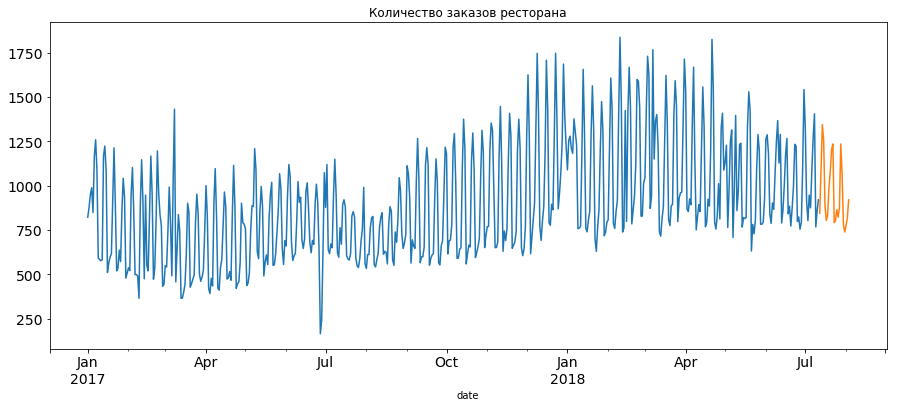

In [7]:
train.orders.plot( figsize=(15,6),title= 'Количество заказов ресторана', fontsize=14)
test.orders.plot( figsize=(15,6),title= 'Количество заказов ресторана', fontsize=14)

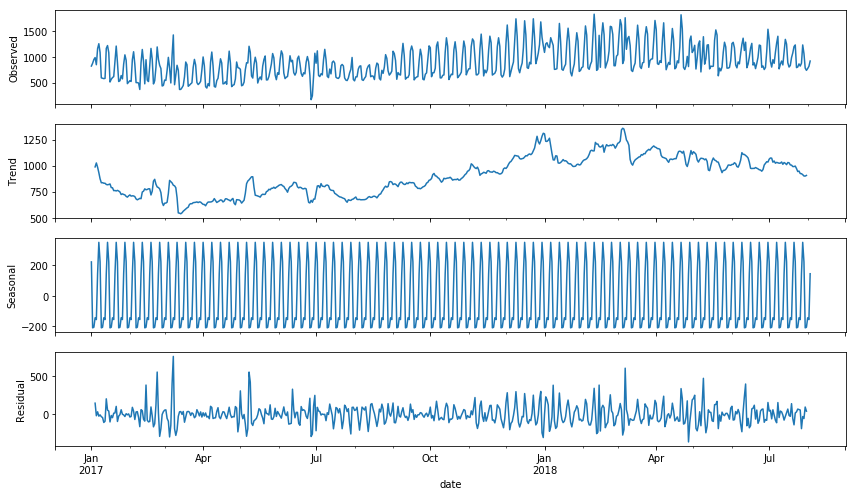

In [6]:
# STL-декомпозиция ряда
rcParams['figure.figsize'] = 12, 7
sm.tsa.seasonal_decompose(restaurant_orders.orders).plot()
plt.show()

**Корреляция** (Пирсона) - сила линейной взаимосвязи между двумя случайными величинами.

Формула выборочной корреляции:
    
 $r_{X_1, X_2}  =\frac{ \sum_{i=1}^n (X_{1i} - \overline{X_1})(X_{2i} - \overline{X_2})}  {\sqrt{\sum_{i=1}^n (X_{1i} - \overline{X_1})^2\sum_{i=1}^n (X_{2i} - \overline{X_2})^2}} $   

**Автокорреляция** (последовательная корреляция) - корреляция между последовательными показателями, упорядоченными во времени.

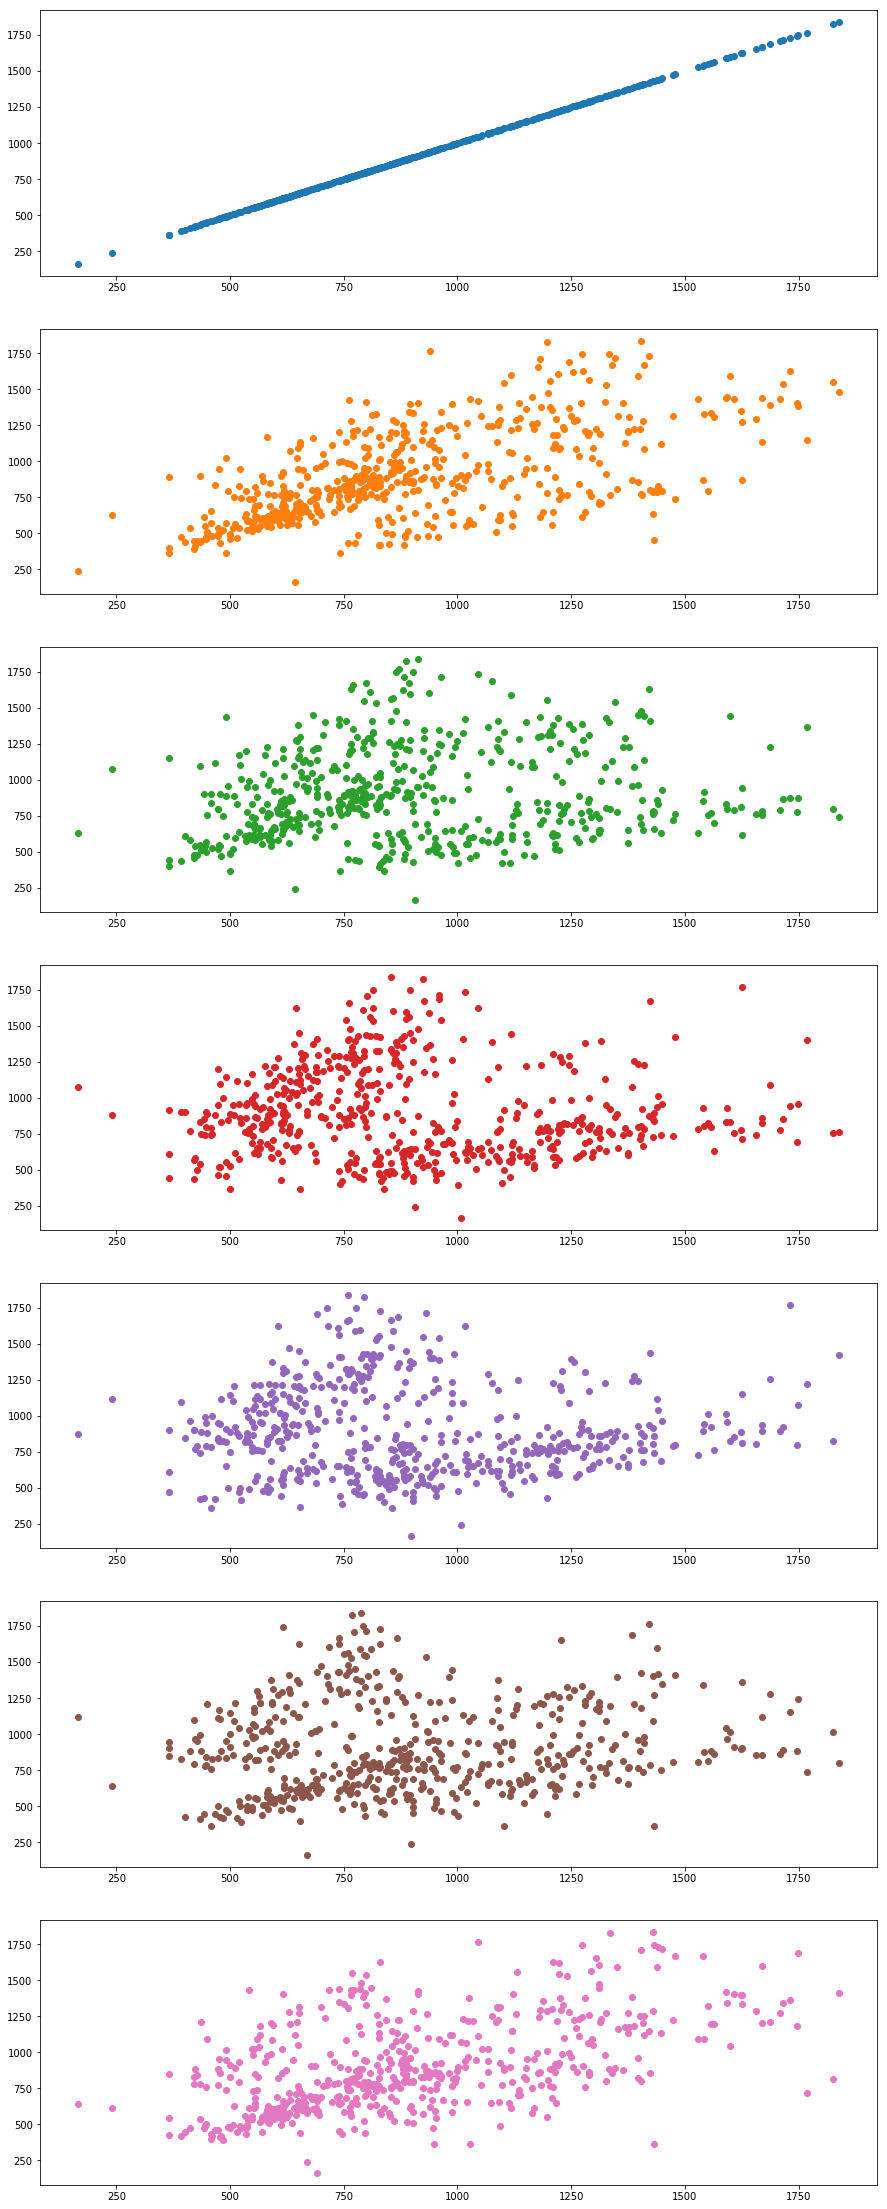

In [8]:
fig, axes = plt.subplots(7,1,figsize = (15,40))
for k, ax in enumerate(axes):
    for i in range(k):
        next(ax._get_lines.prop_cycler)
    ax.plot(train['orders'],train['orders'].shift(-k),'o')


plt.show()

Автокорреляция - корреляция между исходным рядом и его версией, который сдивнут на некий лаг **t** (лаг автокорреляции).

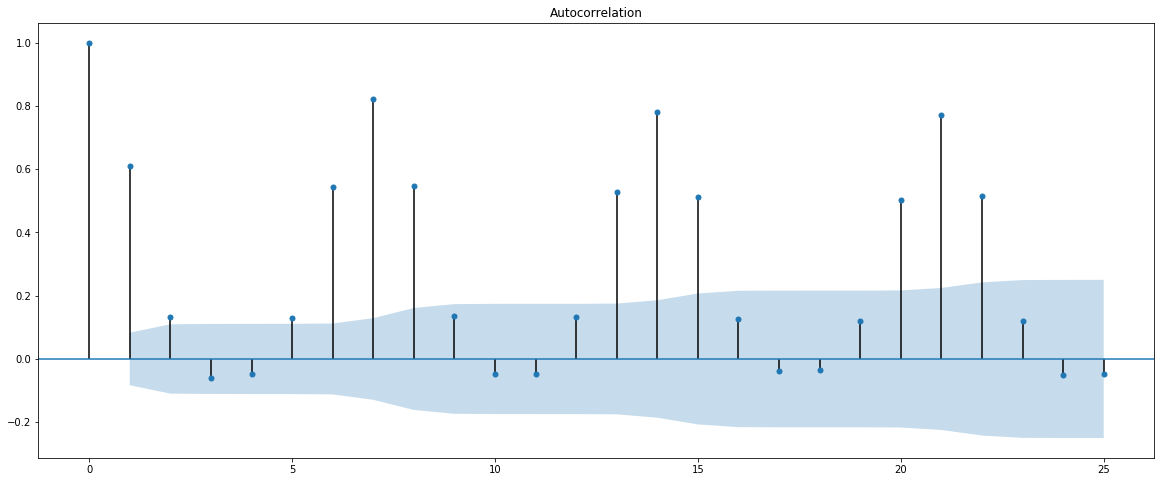

In [19]:
#Коррелограмма
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(train.orders.values, lags=25,ax = ax)
plt.show()

**Стационарность** — свойство процесса не менять свои характеристики со временем: постоянство матожидания, постоянство дисперсии (она же гомоскедастичность) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). 

Подходы для того чтобы сделать временной ряд стационарным:
- в случае непостоянства дисперсии - логарифмирование либо преобразование Бокса-Кокса;
- почти всегда помогает дифференцирование (переход к попарным разностям ряда): стабилизирует среднее значение ряда, может применяться неоднократно, выделяют также сезонное дифференцирование - попарная разность по сезонам.

### Преобразование Бокса-Кокса

<img width = '800px' src="images/lesson_7/box_.png">

In [19]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

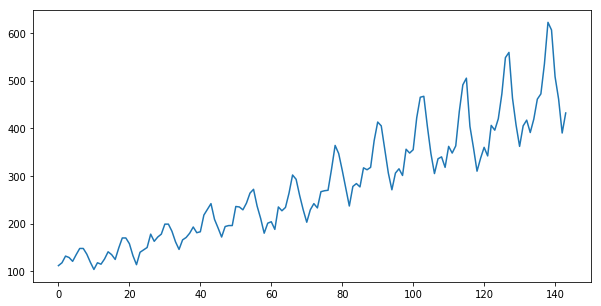

In [20]:
from pandas import Series
x = list(Series.from_csv('files/lesson_7/international-airline-passengers.csv', header=0))

plt.figure(figsize=(10,5))
plt.plot(x)
plt.show()

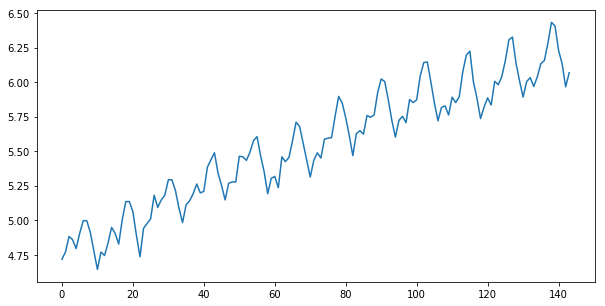

In [21]:
from scipy.stats import boxcox 

xt= boxcox(x,lmbda = 0)


plt.figure(figsize=(10,5))
plt.plot(xt)
plt.show()

Дисперсия гомоскедастична (стабилизирована).

### Наивный подход

Завтра = вчера.

${y}_{t} =  y_{t-n}$

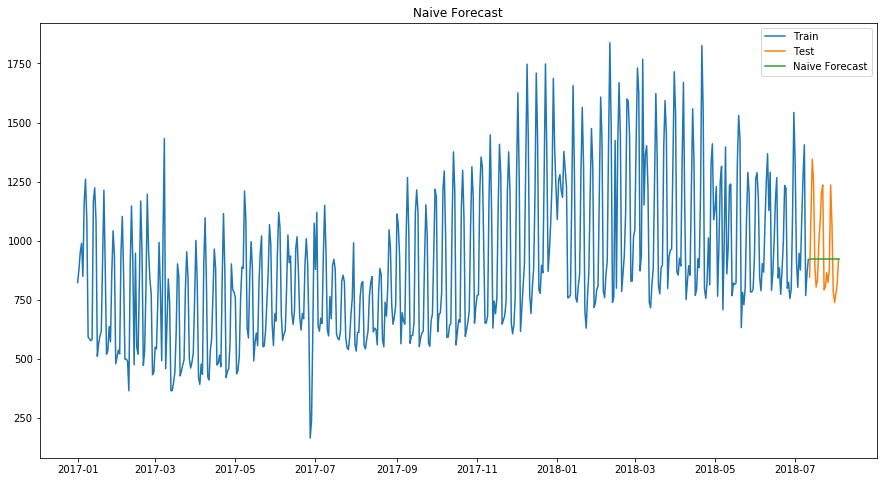

In [23]:
#Здесь будем хранить наши предсказания
y_hat = test.copy()
y_hat['naive'] = train.orders[-1]

plt.figure(figsize=(15,8))
plt.plot(train.index, train.orders, label='Train')
plt.plot(test.index,test.orders, label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

Посчитаем, как мы ошиблись.

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.orders, y_hat.naive))
print(rms)

187.33763984941154


### Среднее/скользящее среднее

Новое значение будет вычисляться на основе среднего за конкретный период.

$${y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$$

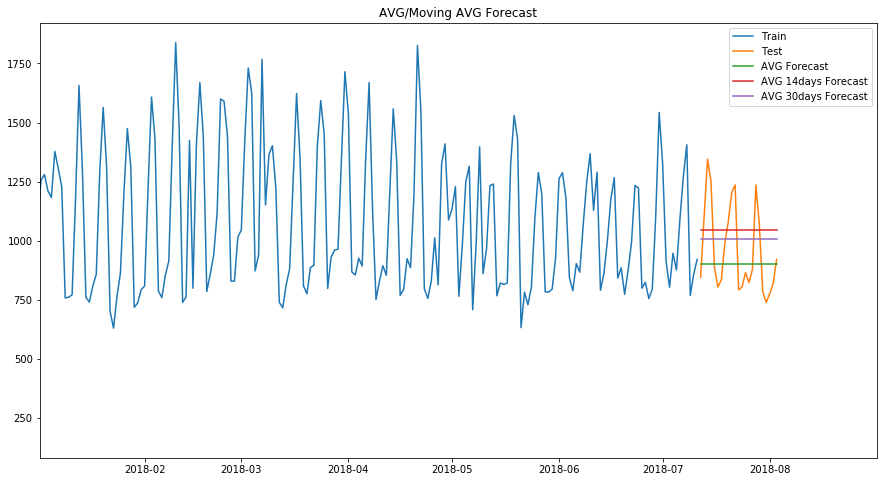

In [29]:
y_hat['avg_forecast'] = train.orders.mean()
y_hat['moving_avg_14days_forecast'] = train.orders.rolling(14).mean().iloc[-1]
y_hat['moving_avg_30days_forecast'] = train.orders.rolling(30).mean().iloc[-1]
# y_hat['moving_avg_60days_forecast'] = train.orders.rolling(60).mean().iloc[-1]

plt.figure(figsize=(15,8))
plt.plot(train.index, train.orders, label='Train')
plt.plot(test.index,test.orders, label='Test')
plt.plot(y_hat.index,y_hat['avg_forecast'], label='AVG Forecast')
plt.plot(y_hat.index,y_hat['moving_avg_14days_forecast'], label='AVG 14days Forecast')
plt.plot(y_hat.index,y_hat['moving_avg_30days_forecast'], label='AVG 30days Forecast')
# plt.plot(y_hat.index,y_hat['moving_avg_60days_forecast'], label='AVG 60days Forecast')
plt.legend(loc='best')
plt.title("AVG/Moving AVG Forecast")
plt.xlim(datetime.datetime(2018, 1, 1, 14, 0, 0, 0))
plt.show()

In [30]:
rms = sqrt(mean_squared_error(test.orders, y_hat.avg_forecast))
print(rms)
rms = sqrt(mean_squared_error(test.orders, y_hat.moving_avg_14days_forecast))
print(rms)
rms = sqrt(mean_squared_error(test.orders, y_hat.moving_avg_30days_forecast))
print(rms)

192.92819952286555
201.94168599631584
189.2721097940574


### Взвешенное среднее

$${y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$$

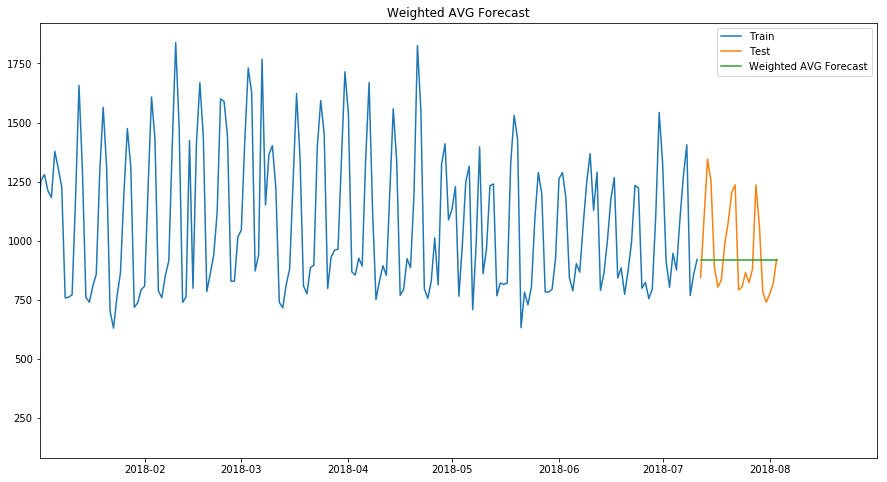

In [31]:
y_hat['weighted_avg'] = np.sum(train.orders[-4:] * [0.1,0.2,0.3,0.4])

plt.figure(figsize=(15,8))
plt.plot(train.index, train.orders, label='Train')
plt.plot(test.index,test.orders, label='Test')
plt.plot(y_hat.index,y_hat['weighted_avg'], label='Weighted AVG Forecast')

plt.legend(loc='best')
plt.title("Weighted AVG Forecast")
plt.xlim(datetime.datetime(2018, 1, 1, 14, 0, 0, 0))
plt.show()

In [32]:
rms = sqrt(mean_squared_error(test.orders, y_hat.weighted_avg))
print(rms)

187.48380451794154


### Экспоненциальное сглаживание

Будем учитывать все наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные.

$${y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

In [33]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result[-1]

In [44]:
#Простой пример
series_val = [1,2,3,4,5,6]

result = [series_val[0]]

#alpha - насколько сильно мы не хотим помнить, что было в прошлом
alpha = 0.9
#alpha = 0.1

for n in range(1, len(series_val)):
    result.append(alpha * series_val[n] + (1 - alpha) * result[n-1])
    
result   

[1, 1.9, 2.89, 3.8890000000000002, 4.8889, 5.88889]

In [45]:
# !pip install statsmodels==0.9.0rc1

In [46]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

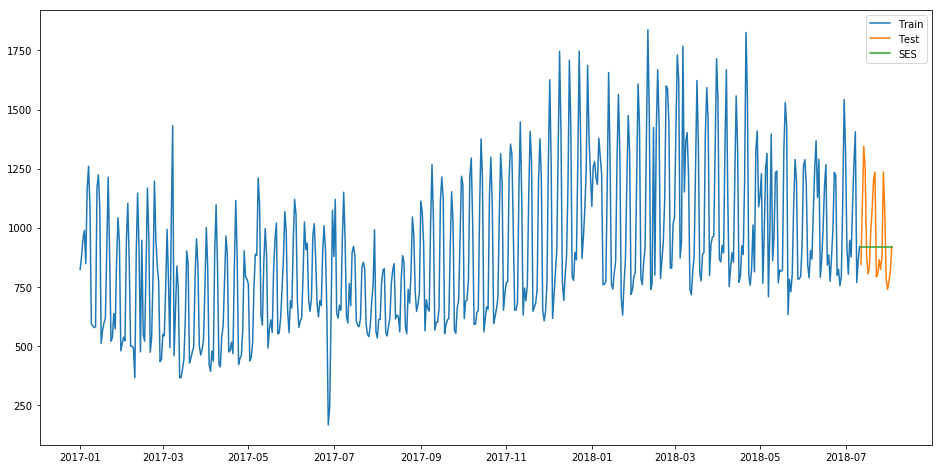

In [47]:
fit2 = SimpleExpSmoothing(np.asarray(train.orders)).fit(smoothing_level=0.6,optimized=False)
y_hat['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train.orders, label='Train')
plt.plot(test.orders, label='Test')
plt.plot(y_hat['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [48]:
rms = sqrt(mean_squared_error(test.orders, y_hat.SES))
print(rms)

188.3447724498066


Все рассмотренные способы не очень подходят для прогнозирования данных с высоким разбросом, не учитываются компоненты временного ряда, могут подойти для прогнозирования на **один** шаг вперед либо для сглаживания.

### Метод линейного тренда Холта-Уинтерса

Подходит для работы с временными рядами, где есть устойчивый линейный тренд.

У нас есть следующие компоненты:

- линейное уравнение для построения прогноза    
${y}_{x+1} = \ell_x + b_x$    
- уравнение уровня    
$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$
- уравнение тренда    
${b_x} = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$


Итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [49]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result[-1]

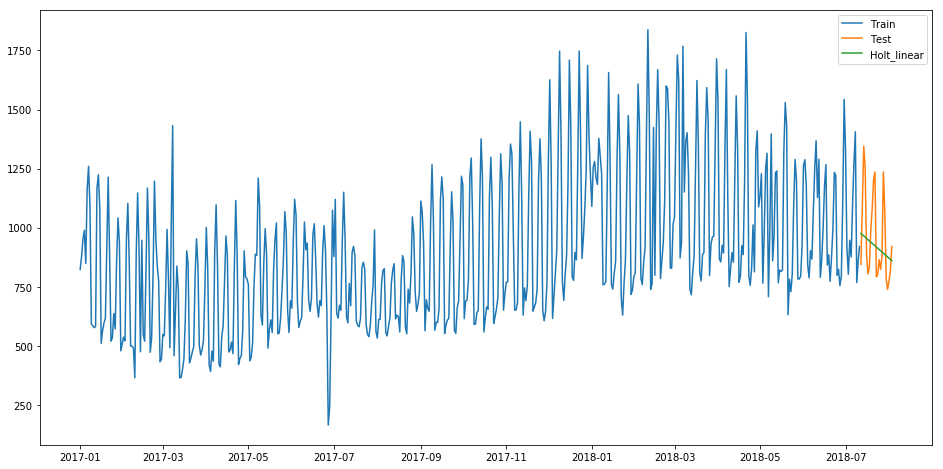

In [50]:
fit1 = Holt(np.asarray(train.orders)).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train.orders, label='Train')
plt.plot(test.orders, label='Test')
plt.plot(y_hat['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [51]:
rms = sqrt(mean_squared_error(test.orders, y_hat.Holt_linear))
print(rms)

178.03422321292982


### Метод Холта-Уинтерса

Теперь будем учитывать сезонность.

Получаем новую систему:

$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$


$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$

$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$

${y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$


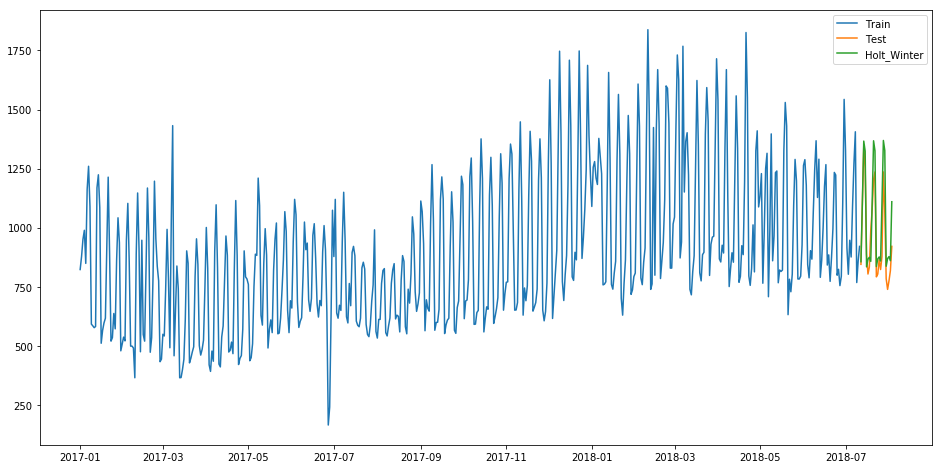

In [55]:
fit1 = ExponentialSmoothing(np.asarray(train.orders) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train.orders, label='Train')
plt.plot(test.orders, label='Test')
plt.plot(y_hat['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [56]:
rms = sqrt(mean_squared_error(test.orders, y_hat.Holt_Winter))
print(rms)

110.34432717144458


### ARIMA

В основе моделей класса ARIMA лежит понятие автокорреляции и плавающего среднего.

<img width = '400px' src="images/lesson_7/arma.png">

$ p(AR(p)): y_{t} - \text {линейная комбинация p предыдущих значений ряда и шумовой компоненты}.$


$ q(MA(q)): y_{t} - \text {линейная комбинация q последних значений шумовой компоненты}.$

ARIMA - линейная модель множественной регрессии, в которой в качестве объяснящих переменных выступают прошлые значения самой зависимой переменной, а в качестве регрессионного остатка - скользящие средние из элементов белого шума.

Для корректного использование модели ARIMA исходный ряд должен быть стационарен.

Проверим это с помощью критерия Дики-Фуллера.

$ q(MA(q)): y_{t} - \text {линейная комбинация q последних значений шумовой компоненты}.$

ARIMA - линейная модель множественной регрессии, в которой в качестве объяснящих переменных выступают прошлые значения самой зависимой переменной, а в качестве регрессионного остатка - скользящие средние из элементов белого шума.

Для корректного использование модели ARIMA исходный ряд должен быть стационарен.

Проверим это с помощью критерия Дики-Фуллера.

In [57]:
test_ = sm.tsa.adfuller(train.orders)
print ('adf: ', test_[0] )
print ('p-value: ', test_[1])
print('Critical values: ', test_[4])
if test_[0]> test_[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -1.3122494727218053
p-value:  0.623549698287515
Critical values:  {'1%': -3.4425861905056556, '5%': -2.8669372502674824, '10%': -2.5696445454608505}
есть единичные корни, ряд не стационарен


Самый частый прием для того, чтобы избавиться от стационарности - провести интегрирование по ряду.

train_diff = train.orders.diff(periods=7).dropna()

В коде выше функция diff() вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр period. Т.к. в разности первое значение получиться неопределенным, то нам надо избавиться от него для этого и используется метод dropna().

plt.figure(figsize=(16,8))
plt.plot(train_diff, label='Train')
plt.show()

In [68]:
train_diff = train.orders.diff(periods=7).dropna()

В коде выше функция diff() вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр period. Т.к. в разности первое значение получиться неопределенным, то нам надо избавиться от него для этого и используется метод dropna().

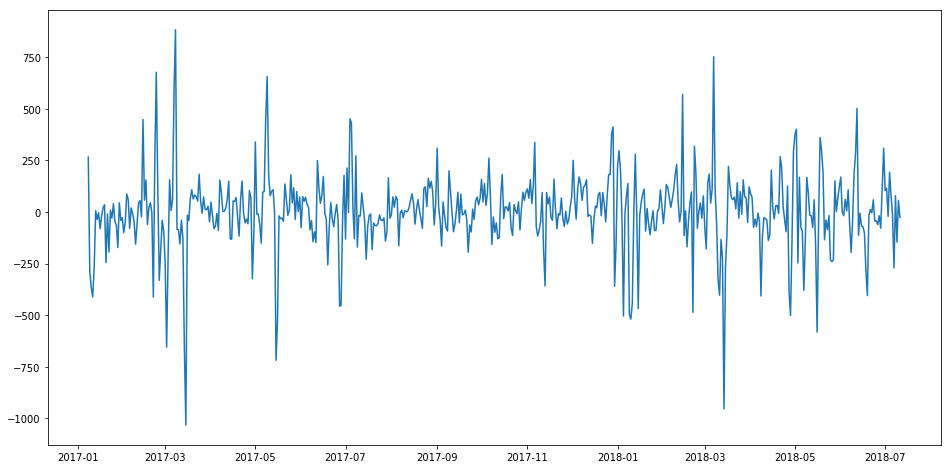

In [69]:
plt.figure(figsize=(16,8))
plt.plot(train_diff, label='Train')
plt.show()

In [70]:
stat_test = sm.tsa.adfuller(train_diff)
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -7.912695530744193
p-value:  3.909501750052714e-12
Critical values:  {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}
единичных корней нет, ряд стационарен


Будем строить модель SARIMA, модель, учитывающая сезонность ряда.

Чтобы построить модель нам нужно знать ее порядок, состоящий из 6-х параметров:

- p,P — порядок компоненты AR
- d,D — порядок интегрированного ряда
- q,Q — порядок компонетны MA

Параметр D равен 1, так как потребовалось делать сезонное дифференцирование.

Для p,P и q,Q надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q и Q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA.
PACF поможет нам определить p и P, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

Подробнее про АКФ и ЧКФ - здесь http://university.prognoz.ru/biu/ru/%D0%90%D0%9A%D0%A4_%D0%B8_%D0%A7%D0%90%D0%9A%D0%A4.

**Автокорреляционная функция** – это зависимость коэффициентов автокорреляции от лага.

**Частная автокорреляционная функция** показывает корреляцию между двумя случайными переменными за вычетом влияния всех внутренних значений автокорреляции. 

<img width = '400px' src="images/lesson_7/partial_autocor.png">

Автокорреляция показывает зависимость между y4 и y1, при этом игнорируя эффект от изменения y2 и y3. А частная автокорреляция также показывает эффект между y4 и y1, при этом учитывая, что эффект от y2 и y3 отсутсвует, то есть убирает эффекты y2 и y3.

Рекомендации к подбору первоначальных приближений:

Q,P - номер последнего сезонного лага при котором автокорреляция значима (персекается граница доверительного интервала).

q,p - номер последнего несезонного лага при котором автокорреляция значима.

Q,P - номер последнего сезонного лага при котором автокорреляция значима (персекается граница доверительного интервала).

q,p - номер последнего несезонного лага при котором автокорреляция значима.



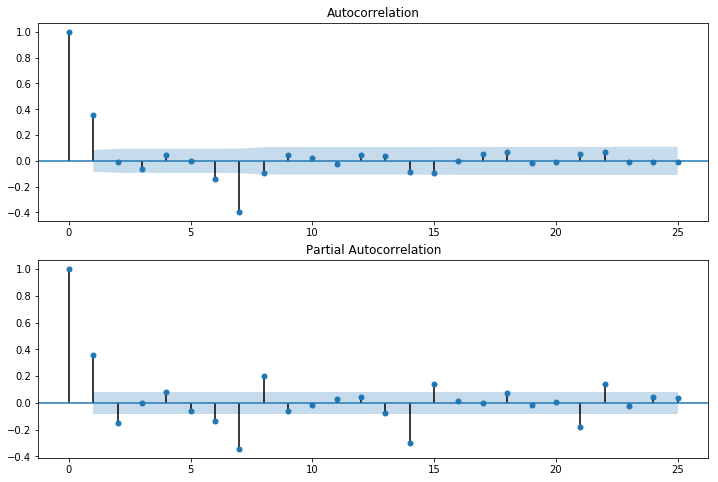

In [71]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_diff, lags=25, ax=ax2)

In [95]:
#ACF
q = 6
Q = 0

#Q==7 -> Q=1
#Q < 3 q <7

#PACF
p = 2
# p = 6
P = 3

d = 0
D = 1

s = 7 

In [96]:
%%time
best_model=sm.tsa.statespace.SARIMAX(train.orders.squeeze(), order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit()

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 33.1 s, sys: 58.4 s, total: 1min 31s
Wall time: 11.6 s


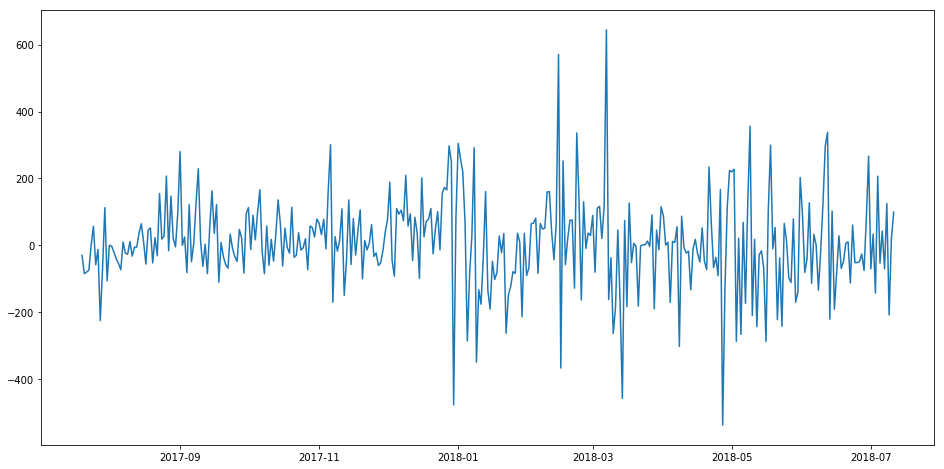

In [97]:
# Остатки модели
plt.figure(figsize=(16,8))
plt.plot(best_model.resid[200:], label='Train')
plt.show()

In [98]:
stat_test = sm.tsa.adfuller(best_model.resid[200:])
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -19.31398779976257
p-value:  0.0
Critical values:  {'1%': -3.448853029339765, '5%': -2.869693115704379, '10%': -2.571113512498422}
единичных корней нет, ряд стационарен


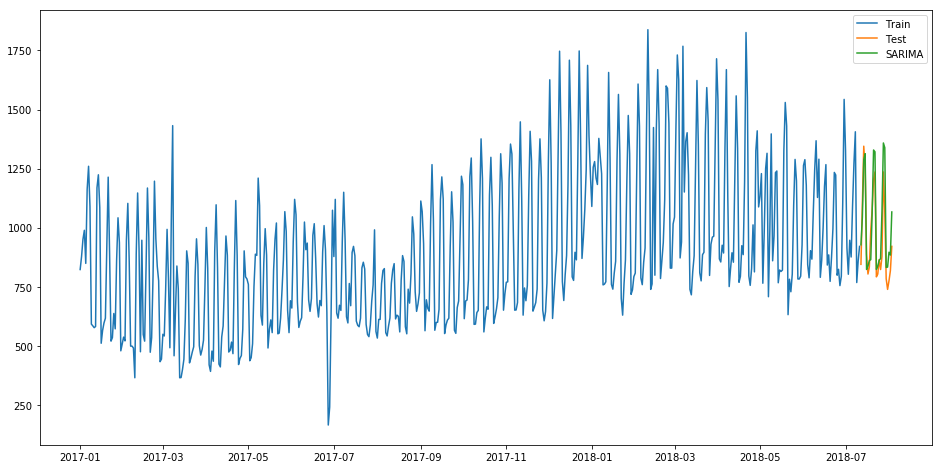

In [99]:
forecast = best_model.predict(start = train.shape[0], end = train.shape[0]+22)
y_hat['SARIMA'] = forecast
plt.figure(figsize=(16,8))
plt.plot( train.orders, label='Train')
plt.plot(test.orders, label='Test')
plt.plot(y_hat['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [100]:
rms = sqrt(mean_squared_error(test.orders, y_hat.SARIMA))
print(rms)

102.58259450144439


### Упражнение

In [78]:
restaurant_orders_ = pd.read_csv('files/lesson_7/train.csv', sep =',')

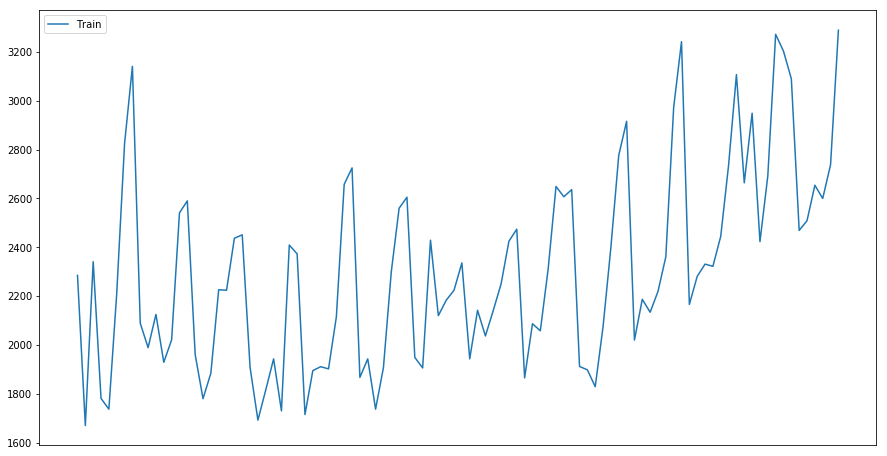

In [74]:
plt.figure(figsize=(15,8))
plt.plot(restaurant_orders_['orders'], label='Train')

plt.legend(loc='best')
plt.xticks([])
plt.show()